<a href="https://colab.research.google.com/github/MASSIMOQSELLA/MyAKarpathyMicrogradTest/blob/main/Sigla_NP_Zhang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

newtwork of 784 input, 128 1st layer, 64 2nd layer and 1 output
Drive already mounted.
Original data shape: (42000, 785)
Train set> data: (6700, 784), labels: (6700, 1), True: 3346, False: 3354
Test  set> data: (838, 784), labels: (838, 1), True: 411, False: 427 
Verification set> data: (838, 784), labels: (838, 1), True: 431, False: 407
learning the digit 9
reshuffling training data each 100 epochs
Epoch    0/1000, LR= 0.8000, Training set: Loss= 0.7225, Verification set: Loss= 0.6438, Accuracy= 0.6611
Epoch  100/1000, LR= 0.7996, Training set: Loss= 0.1590, Verification set: Loss= 0.1851, Accuracy= 0.9356
Epoch  200/1000, LR= 0.7984, Training set: Loss= 0.1117, Verification set: Loss= 0.1409, Accuracy= 0.9535
Epoch  300/1000, LR= 0.7967, Training set: Loss= 0.0868, Verification set: Loss= 0.1226, Accuracy= 0.9547
Epoch  400/1000, LR= 0.7939, Training set: Loss= 0.0679, Verification set: Loss= 0.1050, Accuracy= 0.9570
Epoch  500/1000, LR= 0.7910, Training set: Loss= 0.0556, Verificati

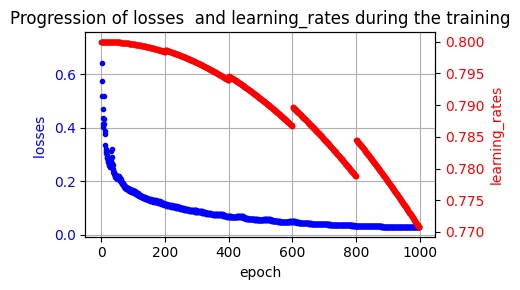

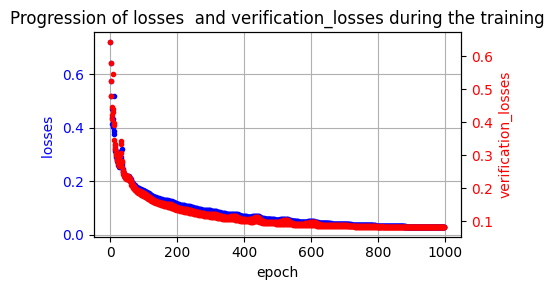

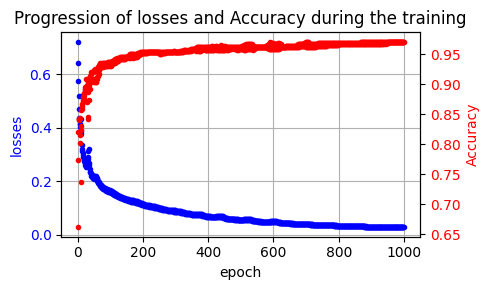

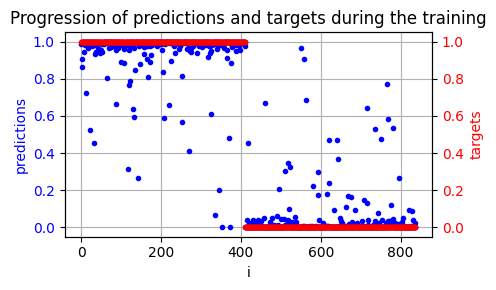

Label: Good Prediction (label=1) 28: [0.99990499] vs label [1]


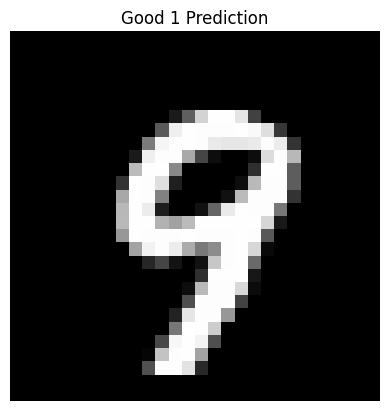

Label: Good Prediction (label=0) 753: [2.5100837e-05] vs label [0]


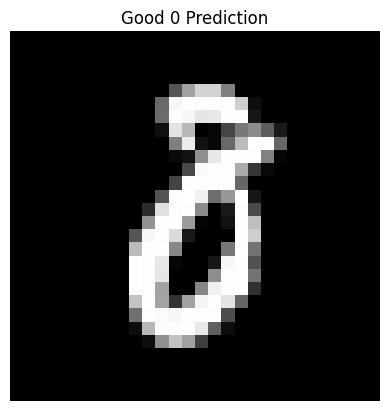

Label: Bad Prediction 321: [0.26400855] vs label [1]


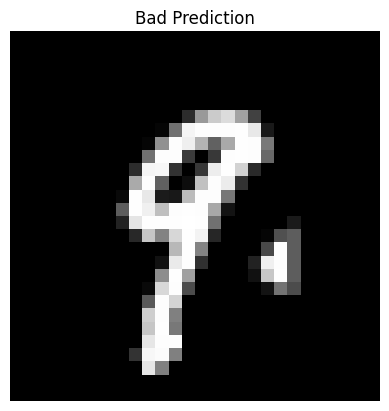

Label: Average Prediction 204: [0.66275638] vs label [1]


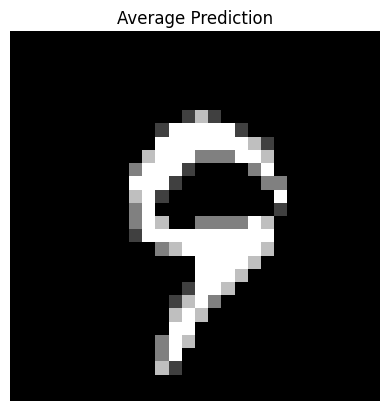

In [28]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
import logging
from google.colab import drive
from copy import deepcopy
import json

# Configurazione del file di log
logging.basicConfig(
    filename='app.log',      # Nome del file di log
    level=logging.DEBUG,     # Livello di log (DEBUG per messaggi dettagliati)
    format='%(asctime)s - %(levelname)s - %(message)s'
)

#!git clone https://github.com/MASSIMOQSELLA/MyAKarpathyMicrogradTest.git


def check_drive():
  if not os.path.exists("/content/drive/"):
    print("Drive not mounted. Mounting...")
    drive.mount("/content/drive/")
  else:
    print("Drive already mounted.")

def input_set(data_vectors_path, digit): # carica i dati di input dal repository e li restituisce per la elaborazione

  if not isinstance(digit, int) or digit not in range(10):
    raise ValueError("digit must be an integer between 0 and 9")

  # Caricamento dei dati
  try:

    #RICORDA: inserisci i comandi per fare lo split dell'unico data set preso dal file di train

    data_vectors_orig = pd.read_csv(data_vectors_path)
    print(f"Original data shape: {data_vectors_orig.shape}")

    # fa una copia
    data_vectors = data_vectors_orig.copy();

    #binarizzare le etichette, 1 solo sul digit 3, zero sugli altri
    data_vectors.iloc[:, 0] = (data_vectors.iloc[:, 0] == digit).astype(int)

    # Step 1: Dividi i dati in base alle etichette
    data_class_1 = data_vectors[data_vectors.iloc[:, 0] == 1]
    data_class_0 = data_vectors[data_vectors.iloc[:, 0] == 0]

    # Step 2: Trova il numero minimo di esempi tra le due classi
    min_samples = min(len(data_class_1), len(data_class_0))

    # Step 3: Sottocampiona entrambe le classi
    data_class_1_balanced = data_class_1.sample(n=min_samples, random_state=42)
    data_class_0_balanced = data_class_0.sample(n=min_samples, random_state=42)

    # Step 4: Unisci i due sottoinsiemi
    balanced_data = pd.concat([data_class_1_balanced, data_class_0_balanced])

    # Mescola i dati bilanciati (opzionale ma consigliato)
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    X_data = balanced_data.iloc[:, 1:].values / 255.0
    y_data = balanced_data.iloc[:, 0].to_numpy().reshape(-1, 1)

    # Suddividi il train set (esempio: 80% training, 20% validation)
    X_train, X_test_ver, y_train, y_test_ver = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42)

    X_test, X_ver, y_test, y_ver = train_test_split(
    X_test_ver, y_test_ver, test_size=0.5, random_state=42)

    # conteggio false vs vere all'interno del train_set e del test_set
    train_false_num = np.count_nonzero(y_train == 0)
    train_real_num = np.count_nonzero(y_train == 1)
    test_false_num = np.count_nonzero(y_test == 0)
    test_real_num = np.count_nonzero(y_test == 1)
    ver_real_num = np.count_nonzero(y_ver == 1)
    ver_false_num = np.count_nonzero(y_ver == 0)
    print(f"Train set> data: {X_train.shape}, labels: {y_train.shape}, True: {train_real_num}, False: {train_false_num}")
    print(f"Test  set> data: {X_test.shape}, labels: {y_test.shape}, True: {test_real_num}, False: {test_false_num} ")
    print(f"Verification set> data: {X_ver.shape}, labels: {y_ver.shape}, True: {ver_real_num}, False: {ver_false_num}")

  except Exception as e:
    logging.error(f"An error occurred during data set processing with input_set : {e}")
    raise

  return X_train, X_test, X_ver, y_train, y_test, y_ver

class SimpleNN:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        # Inizializza i pesi e i bias con He per ReLU
        #layer 1
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2. / input_size)
        self.b1 = np.random.randn(1, hidden_size1) * 0.01  # Piccoli valori casuali
        #layer 2
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2. / hidden_size1)
        self.b2 = np.random.randn(1, hidden_size2) * 0.01
        #output layer
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2. / hidden_size2)
        self.b3 = np.random.randn(1, output_size) * 0.01


    def params(self):
        #Restituisce i parametri (pesi e bias) del modello come un dizionario
        return {
            'W1': self.W1, 'b1': self.b1,
            'W2': self.W2, 'b2': self.b2,
            'W3': self.W3, 'b3': self.b3
        }

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
      return Z > 0  # Restituisce un array booleano (True/False) che diventa 1/0

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def forward(self, X):
        # Passo forward
        # layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        # layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        # output layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)

        return self.A3

    def compute_loss(self, X, y):
        #Calcola la funzione di loss utilizzando la Binary Cross-Entropy (BCE)
        predictions = self.forward(X)

        # Aggiungi un epsilon per evitare log(0) e garantire stabilità numerica
        epsilon = 1e-10
        predictions = np.clip(predictions, epsilon, 1 - epsilon)  # Restringi i valori tra [epsilon, 1 - epsilon]

        # Calcola la BCE
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

        return float(loss)

    def backward(self, X, y):

        # Calcolare l'errore (output - vero valore)
        m = X.shape[0]  # Numero di esempi nel batch


        # output layer gradients
        dA3 = self.A3 - y
        dZ3 = dA3 * self.sigmoid_derivative(self.Z3)
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        # Layer 2 gradients
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Layer 1 gradients
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return {
            'W1': dW1, 'b1': db1,
            'W2': dW2, 'b2': db2,
            'W3': dW3, 'b3': db3
        }

def time_based_decay(self, initial_learning_rate, decay_rate, epoch):
    self.initial_learning_rate = initial_learning_rate
    self.decay_rate = decay_rate
    self.epoch = epoch
    learning_rate = self.initial_learning_rate / (1 + self.decay_rate * self.epoch)
    return learning_rate

class my_data_collection:

  def __init__(self):
    self._data = []

  def collect_data(self, *args):
    self._data.append(tuple(
        np.copy(arg) if isinstance(arg, np.ndarray) else deepcopy(arg)
        for arg in args
    ))

  def __repr__(self):
        # Aggiunge un metodo di rappresentazione per debug e analisi dei dati.
        return f"my_data_collection(data={self._data})"

# Funzione per calcolare l'accuratezza
def compute_accuracy(y_pred, y_true):
    predictions = (y_pred >= 0.5).astype(int)  # Soglia 0.5
    return np.mean(predictions == y_true)  # Percentuale di predizioni corrette

def visualize_samples(t_b, t_l, preds):
    # Numero di immagini da selezionare
    num_random_images = 100

    # Seleziona 100 indici casuali
    random_indices = np.random.choice(range(len(t_b)), num_random_images, replace=False)

    # Variabili per immagazzinare le immagini e le etichette
    images_vector = {'good_1': [], 'good_0': [], 'bad': [], 'average': []}
    labels_vector = {'good_1': [], 'good_0': [], 'bad': [], 'average': []}

    # Contatori per le categorie
    count_good_1 = 0
    count_good_0 = 0
    count_bad = 0
    count_average = 0

    for i in random_indices:
        # Predizione e etichetta
        prediction = preds[i]
        label = t_l[i]

        if abs(prediction - label) < 0.3:  # Good prediction (accurate)
            if label == 1 and count_good_1 < 1:
                # Good prediction with label = 1
                images_vector['good_1'].append(t_b[i])
                labels_vector['good_1'].append(f"Good Prediction (label=1) {i}: {prediction} vs label {label}")
                count_good_1 += 1
            elif label == 0 and count_good_0 < 1:
                # Good prediction with label = 0
                images_vector['good_0'].append(t_b[i])
                labels_vector['good_0'].append(f"Good Prediction (label=0) {i}: {prediction} vs label {label}")
                count_good_0 += 1
        elif abs(prediction - label) > 0.7 and count_bad < 1:  # Bad prediction (incorrect)
            # Bad prediction
            images_vector['bad'].append(t_b[i])
            labels_vector['bad'].append(f"Bad Prediction {i}: {prediction} vs label {label}")
            count_bad += 1
        elif 0.3 <= abs(prediction - label) <= 0.7 and count_average < 1:  # Average prediction
            # Average prediction
            images_vector['average'].append(t_b[i])
            labels_vector['average'].append(f"Average Prediction {i}: {prediction} vs label {label}")
            count_average += 1

        # Esci se tutte le categorie hanno almeno un esempio
        if count_good_1 >= 1 and count_good_0 >= 1 and count_bad >= 1 and count_average >= 1:
            break

    # Visualizzazione delle immagini per ciascuna categoria
    for category in ['good_1', 'good_0', 'bad', 'average']:
        # Verifica che ci sia almeno un'immagine per la categoria
        if images_vector[category]:
            image_vector = images_vector[category][0]  # Vettore 1D
            label = labels_vector[category][0]

            print(f"Label: {label}")
            image_2d = image_vector.reshape(28, 28)  # Ricostruzione in 2D
            plt.imshow(image_2d, cmap='gray')
            plt.title(f"{category.replace('_', ' ').capitalize()} Prediction")
            plt.axis("off")  # Nascondi gli assi
            plt.show()

def save_params(model, filename): #salva in un file i parametri dopo l'apprendimento
    # Estrai i parametri dal modello
    params = model.params()

    # Converte ogni array numpy in una lista per la serializzazione JSON
    params = {key: value.tolist() for key, value in params.items()}

    # Salva il dizionario in un file JSON
    with open(filename, 'w') as f:
        json.dump(params, f)
    print(f"Parametri salvati nel file {filename} della cartella {os.getcwd()}")

def load_params(model, filename): #carica i paranetri da un file per fare una predizione senza ripetere l'apprendimento
    # Carica i parametri dal file JSON
    with open(filename, 'r') as f:
        params = json.load(f)

    # Aggiorna i pesi e i bias del modello con i valori caricati
    model.W1 = np.array(params['W1'])
    model.b1 = np.array(params['b1'])
    model.W2 = np.array(params['W2'])
    model.b2 = np.array(params['b2'])
    model.W3 = np.array(params['W3'])
    model.b3 = np.array(params['b3'])

    print(f"Parametri caricati dal file {filename}")

def train(model, X_train, X_ver, y_train, y_ver, initial_learning_rate, decay_rate, d_h, epochs=1000, reshuffle_int = 200):

     current_learning_rate = initial_learning_rate
     delta_loss = 0
     delta_ver_loss = 0
     count_no_delta_ver =0
     print(f"reshuffling training data each {reshuffle_int} epochs")
     for epoch in range(epochs):

        #------faccio il primo step di apprendimento aggiornando i gradienti in base a loss e learning rate attuali

        # Calcolare la perdita
        loss = model.compute_loss(X_train, y_train)
        # Passo indietro (backward pass)
        gradients = model.backward(X_train, y_train)

        # Aggiorna i pesi e i bias con il gradiente discendente
        model.W1 -= current_learning_rate * gradients['W1']
        model.b1 -= current_learning_rate * gradients['b1']
        model.W2 -= current_learning_rate * gradients['W2']
        model.b2 -= current_learning_rate * gradients['b2']
        model.W3 -= current_learning_rate * gradients['W3']
        model.b3 -= current_learning_rate * gradients['b3']

        # calcolo la loss per il verification step
        ver_loss = model.compute_loss(X_ver, y_ver)

        # Calcolo delle predizioni sul verification set
        y_ver_pred = model.forward(X_ver)

        # Calcolo dell'accuratezza
        accuracy = compute_accuracy(y_ver_pred, y_ver)

        #storicizzo i dati correnti
        d_h.collect_data(epoch, current_learning_rate, loss, delta_loss, ver_loss, delta_ver_loss, accuracy)

        # stampo i dati correnti
        if (epoch == 0) or (epoch % 100 == 0) or (epoch == epochs -1):
          print(f"Epoch {epoch:4}/{epochs}, LR= {current_learning_rate:.4f}, Training set: Loss= {loss:.4f}, Verification set: Loss= {ver_loss:.4f}, Accuracy= {accuracy:.4f}")


        #------- calcolo il prossimo learning rate da applicare e decido se fare il reshuffle degli input

        #calcolare la differenza con la perdita del periodo precedente
        if (epoch != 0):
          delta_loss = (d_h._data[epoch][2] - d_h._data[epoch-1][2])
          delta_ver_loss = (d_h._data[epoch][4] - d_h._data[epoch-1][4])

          # modifica continua del tasso di apprendimento in base al time decay
          lr_td = time_based_decay(model, current_learning_rate, decay_rate, epoch)
          current_learning_rate = lr_td

          # Modifica periodica del tasso di apprendimento in base alla variazione della perdita
          if (epoch % 200 == 0):

            last_delta_losses_ratio = [d_h._data[i][3]/d_h._data[i][2] for i in range(-100, 0)]
            best_delta_loss_ratio = min(last_delta_losses_ratio)  # Trova il valore minimo
            best_index = last_delta_losses_ratio.index(best_delta_loss_ratio)  # Trova l'indice del valore minimo
            last_l_rates =  [d_h._data[i][1] for i in range(-100, 0)]
            best_l_r = last_l_rates[best_index]
            delta_loss_ratio = delta_loss/loss
            if delta_loss_ratio <= best_delta_loss_ratio:
              #print(f" last d_l_ratio: {delta_loss_ratio} is < best_d_l_ratio of last period: {best_delta_loss_ratio} => keep decaying lr: {lr_td})")
              pass
            else:
              #print(f" last d_l_ratio: {delta_loss_ratio} is > best_d_l_ratio of last period: {best_delta_loss_ratio} => reverting lr to: {best_l_r})")
              current_learning_rate = best_l_r

          if (epoch % 10 == 0) and (epoch != 0):

             if ((d_h._data[epoch-10][4] - (d_h._data[epoch][4])) < 0.0000001):
                count_no_delta_ver += 1
                if count_no_delta_ver > 10:
                  print(f"WARNING: ver_loss is decreased of less than 1x10-6 in last {count_no_delta_ver} x 10 cycles")

          if (epoch % reshuffle_int == 0) and (epoch != 0):
              #print(f"Reshuffling data at epoch {epoch}")
              indices = np.arange(X_train.shape[0])
              np.random.shuffle(indices)
              X_train = X_train[indices]
              y_train = y_train[indices]

# genera i grafici sulla base dei dati collezionati
def show_graph(x, x_lable, y1, y1_lable, y2, y2_lable, y1_is_x = False):
  if y1_is_x:
    x = y1
    x_lable = y1_lable

  # Creare il grafico
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(x, y1, marker='.', linestyle='', color='b', label=y1_lable)
  ax1.set_xlabel(x_lable)
  ax1.set_ylabel(y1_lable, color='b')
  ax1.tick_params(axis='y', labelcolor='b')
  ax1.grid(True)
  # asse y secondario
  ax2 = ax1.twinx()
  ax2.plot(x, y2, marker='.', linestyle='', color='r', label=y2_lable)
  ax2.set_ylabel(y2_lable, color='r')
  ax2.tick_params(axis='y', labelcolor='r')
  # Titolo e legende
  plt.title(f'Progression of {y1_lable} and {y2_lable} during the training')
  fig.tight_layout()
  plt.show()

def main():

    mode = 'train'; digit = 9

    # Controlla se sono stati passati gli argomenti dalla riga di comando
    if len(sys.argv) != 3:
        print("Usage: python Sigla_NP_Zhang.py <mode> <digit>")
        sys.exit(1)

    # Ottieni i parametri dalla riga di comando
    #mode = sys.argv[1]  # 'train' o 'predict'
    #digit = int(sys.argv[2])  # La cifra da 0 a 9

    # Verifica che la modalità sia corretta
    if mode not in ['train', 'predict']:
        print("Invalid mode! Use 'train' or 'predict'.")
        sys.exit(1)

    # Imposta il livello di logging
    # Primo messaggio di conferma che il programma è iniziato
    logging.info("Program started.")

    # definisco la collezione dei dati storici da usare per calcolare delta loss e per graficare
    data_hist = my_data_collection()

    # testiamo la rete

    # Parametri della rete
    input_size = 784
    hidden_size1 = 128
    hidden_size2 = 64
    output_size = 1
    initial_learning_rate = 0.8
    decay_rate = 0.0000001
    #digit = 2
    param_fileN = f"params_{digit}.json"

    # Crea la rete neurale
    nn = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)
    print(f"newtwork of {nn.input_size} input, {nn.hidden_size1} 1st layer, {nn.hidden_size2} 2nd layer and {nn.output_size} output")

    # carichiamo gli input
    data_vectors_path = "/content/drive/My Drive/MNIST_Data/Zhang_train.csv"
    check_drive()

    # inputs setup
    train_data, test_data, ver_data, train_labels, test_labels, ver_labels = input_set(data_vectors_path, digit)


#
# bivio: mode train
#

    if mode == 'train':

        # Allenare il modello
        st = time.time()
        print(f"learning the digit {digit}")
        train(nn, train_data, ver_data, train_labels, ver_labels, initial_learning_rate, decay_rate, data_hist, epochs=1000, reshuffle_int = 100)
        save_params(nn, f"/content/drive/My Drive/MNIST_Data/{param_fileN}")

        et = time.time() -st
        print(f"Training done in {et:.4f} sec con {train_data.shape[0]} records, equal to {et/train_data.shape[0]} secs per record")

        # Separare i dati collezionatio per i grafici
        epochs, learning_rates, losses, delta_losses, ver_losses, delta_ver_losses, accuracy = zip(*data_hist._data)

        # Disegna il grafico
        show_graph (epochs, 'epoch', losses , 'losses ', learning_rates , 'learning_rates')
        show_graph (epochs, 'epoch', losses , 'losses ', ver_losses , 'verification_losses')
        show_graph (epochs, 'epoch', losses , 'losses', accuracy, 'Accuracy')

        # Test batch
        test_batch = test_data[:5000]  # Prendi i primi i campioni di test
        test_labels = test_labels[:5000]  # Etichette corrispondenti ai primi i campioni di test
        predictions = nn.forward(test_batch)

        #visualize on a graph
        pred_num = len(predictions[:, 0])
        labels_data = test_labels[test_labels[:, 0] == 1, 0].tolist() + test_labels[test_labels[:, 0] == 0, 0].tolist()
        pred_data = predictions[test_labels[:, 0] == 1, 0].tolist() + predictions[test_labels[:, 0] == 0, 0].tolist()
        show_graph(range(pred_num),'i', pred_data,'predictions', labels_data, 'targets', y1_is_x = False)

        #visualize images samples
        visualize_samples(test_batch, test_labels, predictions)
    #
    # bivio: mode predict
    #

    elif mode == 'predict': #predice per un singolo vettore-immagine
        #carichiamo i parametri
        load_params(nn, f"/content/drive/My Drive/MNIST_Data/{param_fileN}")
        print(f"Pesi caricati per la cifra {digit}.")

        image_vector = test_data[:1]  # Prende il primo  campione di test
        test_label = test_labels[:1]  # Etichetta corrispondente
        prediction = nn.forward(image_vector)
        print(f"prediction for digit {digit} is {prediction}")

        image_2d = image_vector.reshape(28, 28)  # Ricostruzione in 2D
        plt.imshow(image_2d, cmap='gray')
        plt.title(f"{digit} Prediction")
        plt.axis("off")  # Nascondi gli assi
        plt.show()

        return prediction

if __name__ == "__main__":
    main()
